In [29]:
import warnings
warnings.filterwarnings('ignore')

In [264]:
import logging
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Lasso, LinearRegression

In [269]:
# Creating a logger
logging.basicConfig(filename="Output_Files/Final_Project.log",
                            filemode='w',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG)

In [92]:
benchmark_returns_filepath = 'Data/Benchmark Returns.csv'
rus1000_filepath = 'Data/rus1000_stocks_factors.csv'
cleaned_returns_filepath = 'Data/cleaned_return_data_sc.csv'
benchmark_ret_raw = pd.read_csv(benchmark_returns_filepath)
rus1000_raw = pd.read_csv(rus1000_filepath, skiprows=4)
cleaned_ret_raw = pd.read_csv(cleaned_returns_filepath)

# QUESTION 1

In [3]:
def wrangle_benchmark_returns(df):
    df_w = df.copy()
    df_w.columns = df_w.columns.str.upper()
    df_w['DATE'] = pd.to_datetime(df_w['DATE'], format='%Y%m%d', errors='coerce')
    return(df_w)

benchmark_ret_w = wrangle_benchmark_returns(benchmark_ret_raw)

In [61]:
benchmark_stats = {'Portfolio Name' : [], 
                   'Average Return' : [], 
                   'Standard Deviation' : [], 
                   'Information Ratio' : [], 
                   'Maximum Drawdown' : []
                  }

for port_name in benchmark_ret_w.drop(['Date'], axis=1):
    port_ret = benchmark_ret_w[port_name]
    port_ret_mean = port_ret.mean()
    port_ret_std =  port_ret.std()
    port_ir = port_ret_mean / port_ret_std
    port_wealth = (1 + port_ret).cumprod()
    previous_peaks = port_wealth.cummax()
    drawdown = abs((port_wealth - previous_peaks)/previous_peaks)
    port_max_drawdown = drawdown.max()
    benchmark_stats['Portfolio Name'].append(port_name)
    benchmark_stats['Average Return'].append(port_ret_mean)
    benchmark_stats['Standard Deviation'].append(port_ret_std)
    benchmark_stats['Information Ratio'].append(port_ir)
    benchmark_stats['Maximum Drawdown'].append(port_max_drawdown)
    
benchmark_stats_df = pd.DataFrame(benchmark_stats)
    
benchmark_stats_df

,Portfolio Name,Average Return,Standard Deviation,Information Ratio,Maximum Drawdown
0,MSCI EM Bench Return,0.010079,0.060572,0.166403,0.614412
1,Russell 1000 Bench Return,0.008374,0.039763,0.210609,0.511259
2,MSCI ACWIXUS Bench Return,0.007321,0.048117,0.152159,0.573709


# QUESTION 2

In [274]:
def create_date(x):
    date = dt(year=x['YEAR'], month=x['MONTH'], day=x['DAY'])
    return(date)

def wrangle_russel_1000_factors(df):
    df_w = df.copy()
    df_w.columns = df_w.columns.str.upper()
    df_w[['MONTH', 'DAY', 'YEAR']] =  df_w['DATE'].str.split('/', expand=True).astype(int, errors='ignore')
    df_w.loc[:,'RETURN':'LIT'] = df_w.loc[:,'RETURN':'LIT'].apply(pd.to_numeric, errors='coerce')
    df_w['DATE'] = df_w.apply(lambda x: create_date(x), axis=1)
    df_w = df_w.drop(columns=['DAY'])
    df_w = df_w.sort_values(by=['SEDOL', 'DATE'])
    df_w['RETURN_NEXT'] = df_w.groupby('SEDOL')['RETURN'].shift(-1)
    df_w = df_w[~df_w.isin([np.nan, np.inf, -np.inf]).any(1)]
    return(df_w)

rus1000_w = wrangle_russel_1000_factors(rus1000_raw)

In [187]:
bins = list(range(0, 101, 10))
groups = rus1000_w.groupby(pd.cut(rus1000_w['RETURN'], bins))
groups['SEDOL'].count()

RETURN
(0, 10]      16251
(10, 20]     16301
(20, 30]     16370
(30, 40]     16313
(40, 50]     16435
(50, 60]     16362
(60, 70]     16237
(70, 80]     16361
(80, 90]     16283
(90, 100]    16328
Name: SEDOL, dtype: int64

# QUESTION 3

In [329]:
q3_train_df = rus1000_w.loc[(rus1000_w['YEAR'] == 2004) & (rus1000_w['MONTH'].isin([10, 11]))]
q3_test_df = rus1000_w.loc[(rus1000_w['YEAR'] == 2004) & (rus1000_w['MONTH'].isin([12]))]
X_train = q3_train_df.loc[:, 'RETURN':'LIT']
y_train = q3_train_df['RETURN_NEXT']
X_test = q3_test_df.loc[:, 'RETURN':'LIT']
y_test = q3_test_df['RETURN_NEXT']

In [330]:
# Transform independent variables
sc = StandardScaler()
pca = PCA(n_components=10)
X_train = sc.fit_transform(X_train)
X_train = pca.fit_transform(X_train)
X_train = sm.add_constant(X_train)

# Performing regression
reg_ols = sm.OLS(y,X).fit()
logging.info('Rsquared : ' + str(reg_ols.rsquared_adj))
logging.info('FValue : ' + str(reg_ols.fvalue))
logging.info('F PValue : ' + str(reg_ols.f_pvalue))
print(reg_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            RETURN_NEXT   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.365
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           0.000260
Time:                        02:30:10   Log-Likelihood:                -3776.8
No. Observations:                 795   AIC:                             7576.
Df Residuals:                     784   BIC:                             7627.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9145      1.000     49.935      0.0

In [331]:
# Testing out of sample`
X_test = sc.transform(X_test)
X_test = pca.transform(X_test)
X_test = sm.add_constant(X_test)
y_pred = reg_ols.predict(X_test)

# QUESTION 4

In [332]:
y_pred_percentile = pd.qcut(y_pred, 100, labels=False) + 1
reg_ic = sm.OLS(y_pred_percentile, y_test).fit()

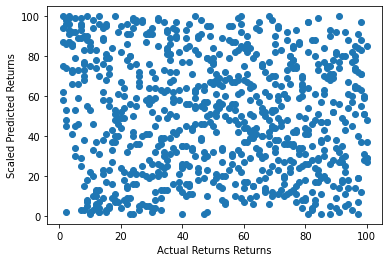

In [339]:
from matplotlib import pyplot as plt
plt.scatter(y_test, y_pred_percentile)
plt.xlabel('Actual Returns Returns')
plt.ylabel('Scaled Predicted Returns')
plt.show()

In [333]:
print(reg_ic.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.543
Model:                            OLS   Adj. R-squared (uncentered):              0.543
Method:                 Least Squares   F-statistic:                              966.4
Date:                Fri, 03 Dec 2021   Prob (F-statistic):                   2.25e-140
Time:                        02:30:32   Log-Likelihood:                         -4138.6
No. Observations:                 813   AIC:                                      8279.
Df Residuals:                     812   BIC:                                      8284.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

# QUESTION 5

# QUESTION 6